<a href="https://colab.research.google.com/github/NazeerSiddique-dev/Nazeer-demo/blob/main/semproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle -q

from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\n✅ Kaggle API configured successfully!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

✅ Kaggle API configured successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!kaggle datasets download -d toygarr/camus-dataset

!unzip -q camus-dataset.zip -d /content/camus_dataset

Dataset URL: https://www.kaggle.com/datasets/toygarr/camus-dataset
License(s): unknown
 96% 473M/493M [00:00<00:00, 407MB/s]
100% 493M/493M [00:01<00:00, 486MB/s]


In [4]:
!ls /content/camus_dataset | head
!ls /content/camus_dataset/patient001  # or whatever the first folder is

image_dataset.hdf5
ls: cannot access '/content/camus_dataset/patient001': No such file or directory


In [5]:
# In-notebook UNet implementation (replaces external repository clone)
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.pool_conv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_ch, out_ch)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=4, bilinear=True):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [6]:
!pip install SimpleITK -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.1 MB/s eta 0:00:00


In [7]:
!ls -l /content/camus_dataset/

total 2073680
-rw-r--r-- 1 root root 2123441736 Mar 15  2023 image_dataset.hdf5


In [8]:
!pip install h5py -q

In [9]:
import torch
import h5py
import numpy as np
from torch.utils.data import Dataset

class CamusHDF5Dataset(Dataset):
    def __init__(self, hdf5_path, transform=None):
        self.hdf5_path = hdf5_path
        self.transform = transform

        with h5py.File(self.hdf5_path, 'r') as file:
            self.len_2ch = len(file['train 2ch frames'])
            self.len_4ch = len(file['train 4ch frames'])
            self.dataset_len = self.len_2ch + self.len_4ch

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_path, 'r') as file:
            if idx < self.len_2ch:
                image = file['train 2ch frames'][idx]
                mask = file['train 2ch masks'][idx]
            else:
                new_idx = idx - self.len_2ch
                image = file['train 4ch frames'][new_idx]
                mask = file['train 4ch masks'][new_idx]


        if mask.ndim == 3 and mask.shape[-1] == 1:
            mask = np.squeeze(mask, axis=-1)

        image = image.astype(np.float32)
        mask = mask.astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = np.expand_dims(image, axis=0)
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)

        return image, mask.long()

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

!pip install -q albumentations

train_transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate(limit=25, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

correct_hdf5_path = '/content/camus_dataset/image_dataset.hdf5'


train_dataset_obj = CamusHDF5Dataset(correct_hdf5_path, transform=train_transform)
val_dataset_obj = CamusHDF5Dataset(correct_hdf5_path, transform=val_transform)

dataset_size = len(train_dataset_obj)
indices = list(range(dataset_size))

train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(train_dataset_obj, train_indices)
val_dataset = Subset(val_dataset_obj, val_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"✅ Data ready for training!")
print(f"Total samples: {dataset_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

✅ Data ready for training!
Total samples: 1800
Training samples: 1440
Validation samples: 360


In [11]:
import torch.optim as optim
import torch.nn as nn

# Use the UNet defined earlier in the notebook
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(n_channels=1, n_classes=4).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

try:

    images, masks = next(iter(train_loader))
    images, masks = images.to(device), masks.to(device)

    output = model(images)

    print("✅ Model, Loss, and Optimizer are set up correctly!")
    print(f"Using device: {device.upper()}")
    print(f"Input batch shape: {images.shape}")
    print(f"Output batch shape: {output.shape}")

except Exception as e:
    print(f"❌ An error occurred during the model test: {e}")

✅ Model, Loss, and Optimizer are set up correctly!
Using device: CUDA
Input batch shape: torch.Size([8, 1, 256, 256])
Output batch shape: torch.Size([8, 4, 256, 256])


In [12]:
# Robust resume cell: put this BEFORE the training loop
import os, torch

ckpt_candidates = ["best_checkpoint.pth", "last_checkpoint.pth"]
ckpt_path = next((p for p in ckpt_candidates if os.path.exists(p)), None)

if ckpt_path:
    ckpt = torch.load(ckpt_path, map_location=device)

    # Restore model/optim
    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    if "scheduler" in globals() and ckpt.get("scheduler_state_dict"):
        scheduler.load_state_dict(ckpt["scheduler_state_dict"])

    # RESTORE LOSS HISTORY HERE (before start_epoch)
    hist = ckpt.get("history")
    if hist:
        epochs_axis = hist.get("epochs_axis", [])
        train_losses = hist.get("train_losses", [])
        val_losses = hist.get("val_losses", [])
        print(f"Restored history with {len(epochs_axis)} logged epochs")

    # Continue from next epoch
    start_epoch = ckpt["epoch"] + 1
    bestvalloss = ckpt.get("best_val_loss", float("inf"))

    model.to(device)
    model.train()
    print(f"Resumed from {ckpt_path} at epoch {start_epoch} with best_val_loss={bestvalloss:.4f}")

elif os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.to(device)
    model.train()
    start_epoch = 0
    bestvalloss = float("inf")
    # Initialize empty history since weights-only contains no history
    epochs_axis, train_losses, val_losses = [], [], []
    print("No checkpoint found; loaded best_model.pth and will start from epoch 0")

else:
    start_epoch = 0
    bestvalloss = float("inf")
    epochs_axis, train_losses, val_losses = [], [], []
    print("No checkpoint or best_model.pth found; starting fresh")


Restored history with 13 logged epochs
Resumed from best_checkpoint.pth at epoch 13 with best_val_loss=0.1019


In [13]:
from tqdm import tqdm
import torch

EPOCHS = 15

# Defaults if not resuming (resume cell sets these if a checkpoint exists)
if "start_epoch" not in globals():
    start_epoch = 0
if "bestvalloss" not in globals():
    bestvalloss = float("inf")
if "train_losses" not in globals():
    train_losses = []
if "val_losses" not in globals():
    val_losses = []
if "epochs_axis" not in globals():
    epochs_axis = []

for epoch in range(start_epoch, EPOCHS):
    print(f"--- Epoch {epoch+1}/{EPOCHS} ---")

    # Train
    model.train()
    runningloss = 0.0
    for images, masks in tqdm(train_loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        runningloss += loss.item()

    avgtrainloss = runningloss / len(train_loader)
    print(f"Average Training Loss {avgtrainloss:.4f}")

    # Validate
    model.eval()
    valloss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validating"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            valloss += loss.item()

    avgvalloss = valloss / len(val_loader)
    print(f"Average Validation Loss {avgvalloss:.4f}")

    # Log for plotting
    train_losses.append(avgtrainloss)
    val_losses.append(avgvalloss)
    epochs_axis.append(epoch + 1)

    # Save best weights + full checkpoint
    if avgvalloss < bestvalloss:
        bestvalloss = avgvalloss
        torch.save(model.state_dict(), "best_model.pth")
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            # "scheduler_state_dict": scheduler.state_dict() if using one,
            "best_val_loss": bestvalloss,
            # Optional: persist history
            "history": {
                "epochs_axis": epochs_axis,
                "train_losses": train_losses,
                "val_losses": val_losses,
            },
        }, "best_checkpoint.pth")
        print("New best model and checkpoint saved!")

    # Rolling "last" checkpoint every epoch (also persist history)
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        # "scheduler_state_dict": scheduler.state_dict() if using one,
        "best_val_loss": bestvalloss,
        "history": {
            "epochs_axis": epochs_axis,
            "train_losses": train_losses,
            "val_losses": val_losses,
        },
    }, "last_checkpoint.pth")

print("Training complete!")


--- Epoch 14/15 ---


Training: 100%|██████████| 180/180 [00:59<00:00,  3.01it/s]


Average Training Loss 0.1056


Validating: 100%|██████████| 45/45 [00:05<00:00,  8.16it/s]


Average Validation Loss 0.1151
--- Epoch 15/15 ---


Training: 100%|██████████| 180/180 [01:02<00:00,  2.87it/s]


Average Training Loss 0.1000


Validating: 100%|██████████| 45/45 [00:05<00:00,  8.18it/s]


Average Validation Loss 0.1218
Training complete!


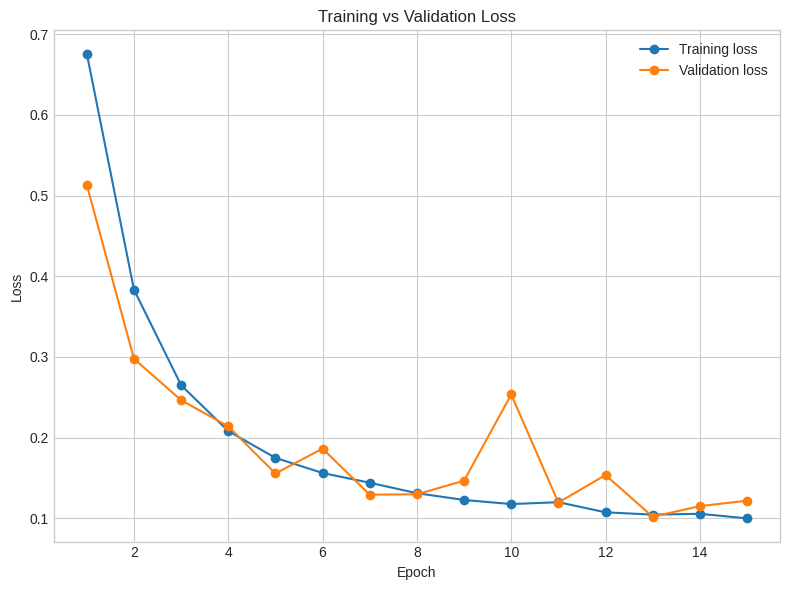

In [14]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))
plt.plot(epochs_axis, train_losses, label="Training loss", marker="o")
plt.plot(epochs_axis, val_losses, label="Validation loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
!pip install scipy -q

Calculating Metrics: 100%|██████████| 45/45 [00:07<00:00,  6.35it/s]



--- Model Performance on Left Ventricle (LV) ---
✅ Average Dice Score: 0.9158
✅ Average IoU Score: 0.8488

Generating performance graph...


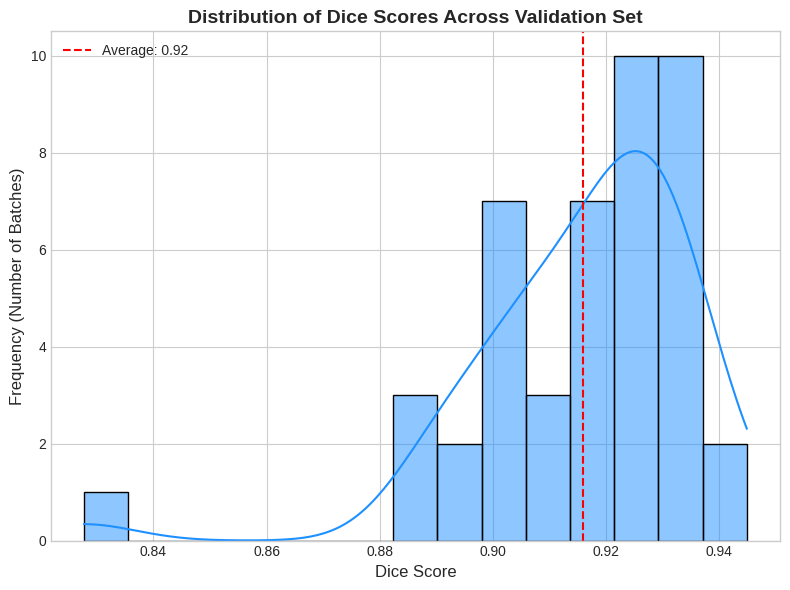


Visualizing separate results...


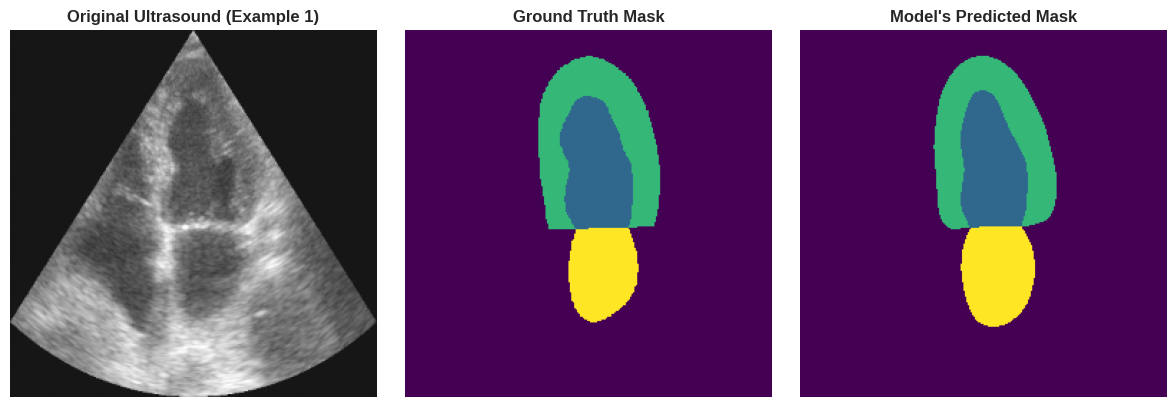

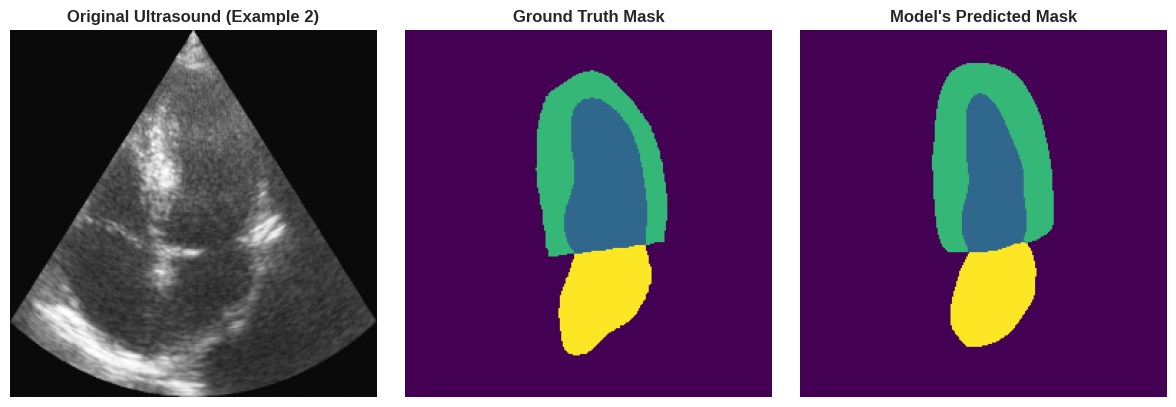

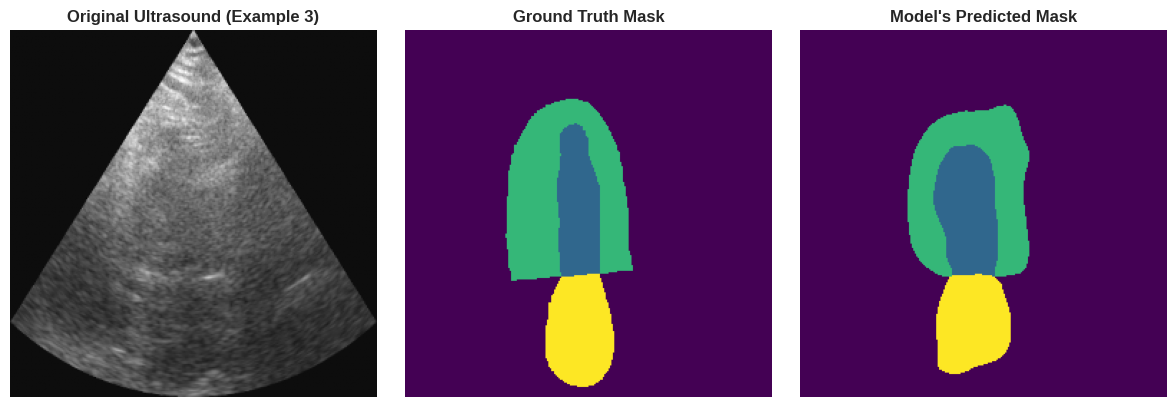

In [16]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import numpy as np
import seaborn as sns

def calculate_metrics(preds, targets, class_index=1):
    preds = torch.softmax(preds, dim=1)
    preds = torch.argmax(preds, dim=1)
    preds_np = preds.cpu().numpy()
    targets_np = targets.cpu().numpy()

    batch_dice, batch_iou = [], []

    for i in range(preds_np.shape[0]):
        pred_class = (preds_np[i] == class_index)
        target_class = (targets_np[i] == class_index)

        intersection = np.sum(pred_class & target_class)
        union_dice = np.sum(pred_class) + np.sum(target_class)
        union_iou = union_dice - intersection

        batch_dice.append((2. * intersection) / (union_dice + 1e-8))
        batch_iou.append(intersection / (union_iou + 1e-8))

    return np.mean(batch_dice), np.mean(batch_iou)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)
model.eval()

all_dice_scores, all_iou_scores = [], []

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Calculating Metrics"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        dice, iou = calculate_metrics(outputs, masks, class_index=1)

        all_dice_scores.append(dice)
        all_iou_scores.append(iou)

print("\n--- Model Performance on Left Ventricle (LV) ---")
print(f"✅ Average Dice Score: {np.mean(all_dice_scores):.4f}")
print(f"✅ Average IoU Score: {np.mean(all_iou_scores):.4f}")

print("\nGenerating performance graph...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.histplot(all_dice_scores, bins=15, kde=True, ax=ax, color='dodgerblue')
ax.set_title('Distribution of Dice Scores Across Validation Set', fontsize=14, weight='bold')
ax.set_xlabel('Dice Score', fontsize=12)
ax.set_ylabel('Frequency (Number of Batches)', fontsize=12)
ax.axvline(np.mean(all_dice_scores), color='red', linestyle='--', label=f'Average: {np.mean(all_dice_scores):.2f}')
ax.legend()
plt.tight_layout()
plt.show()

print("\nVisualizing separate results...")
images, masks = next(iter(val_loader))
images, masks = images.to(device), masks.to(device)
outputs = model(images)
preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1)

images_cpu, masks_cpu, preds_cpu = images.cpu().numpy(), masks.cpu().numpy(), preds.cpu().numpy()

for i in range(3):

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))


    axes[0].imshow(images_cpu[i, 0], cmap='gray')
    axes[0].set_title(f'Original Ultrasound (Example {i+1})', weight='bold')
    axes[0].axis('off')


    axes[1].imshow(masks_cpu[i], cmap='viridis')
    axes[1].set_title('Ground Truth Mask', weight='bold')
    axes[1].axis('off')


    axes[2].imshow(preds_cpu[i], cmap='viridis')
    axes[2].set_title('Model\'s Predicted Mask', weight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()